In [1]:
# %pip install numpy tifffile matplotlib scipy scikit-image pyocclient

In [2]:
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter1d

In [3]:
import owncloud
import os

if not os.path.exists('data'):
    print('Creating directory for data')
    os.mkdir('data')

if not os.path.exists('data/demoMovie.tif'):
    oc = owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/NwtdrIg5wGdeGcB')
    oc.get_file('/', 'data/demoMovie.tif');

# Calcium Traces

## Flurorescence Signals from a Single Pixel.

In this section, let us look at the brightness (fluorescence) of a single pixel over time. This brightness changes when calcium levels in the cell change which is an indicator that the neuron is "active". Plotting how the fluorescence changes shows us when "activity" might have happened in that pixel. 

*How do I look for individual frames in my data to search for neurons?*

**Example** Plot the first frame as representative image.

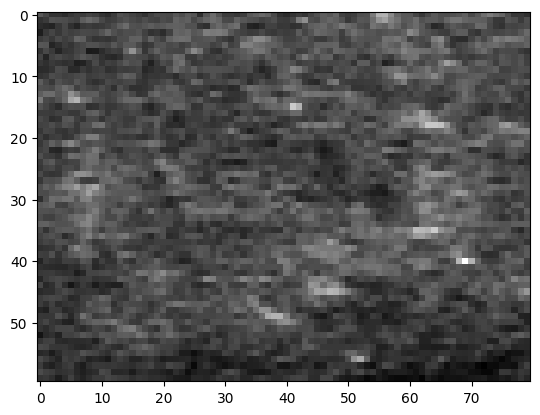

In [4]:
data = imread('data/demoMovie.tif')
rep_image = data[0, :, :]
plt.imshow(rep_image, cmap='gray')

Plot the 116th frame as representative image.

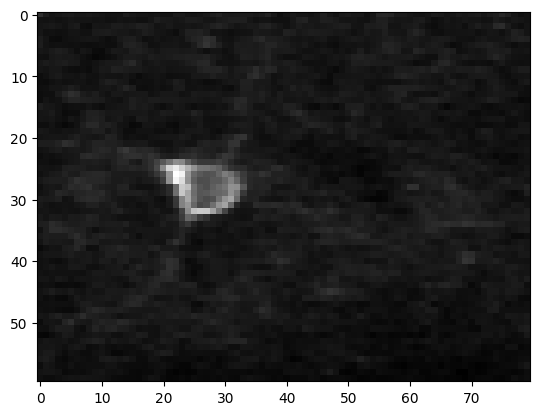

In [5]:
data = imread('data/demoMovie.tif')
rep_image = data[115, :, :]
plt.imshow(rep_image, cmap='gray')

Plot the last frame as representative image.

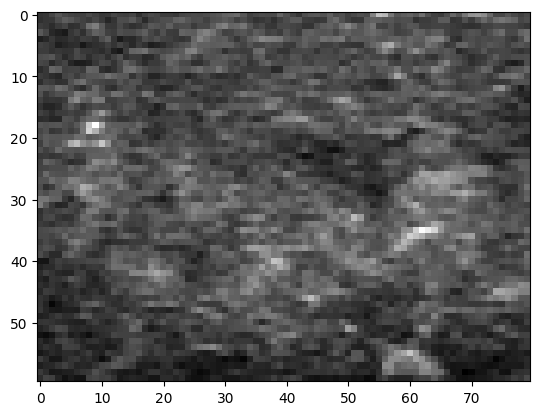

In [6]:
data = imread('data/demoMovie.tif')
rep_image = data[-1, :, :]
plt.imshow(rep_image, cmap='gray')

*How do I see as many active neurons as possible in one image?*

**Example** Plot mean projection of all the frames as representative image.

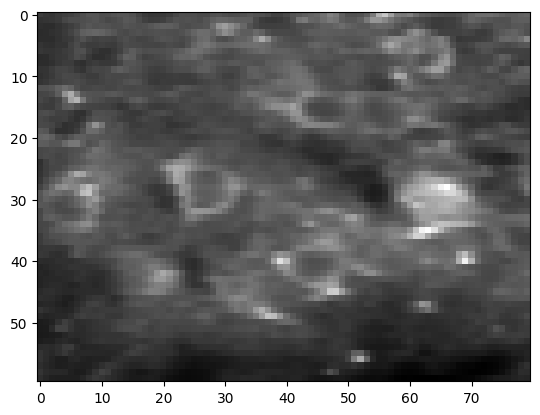

In [7]:
data = imread('data/demoMovie.tif')
rep_image = data[:, :, :].mean(axis=0)
plt.imshow(rep_image, cmap='gray')

Plot the maximum projection of all frames as representative image.

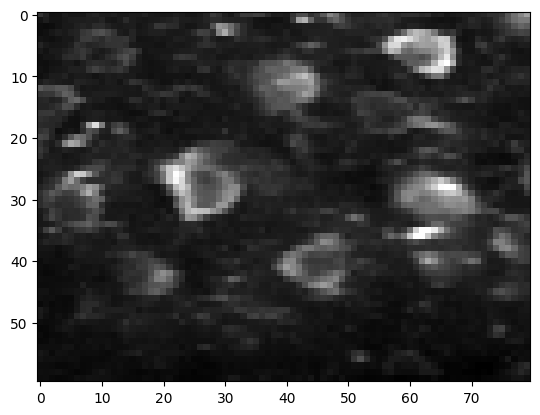

In [8]:
data = imread('data/demoMovie.tif')
rep_image = data.max(axis=0)
plt.imshow(rep_image, cmap='gray')

Plot maximum projection from 100th to 500th frame only.

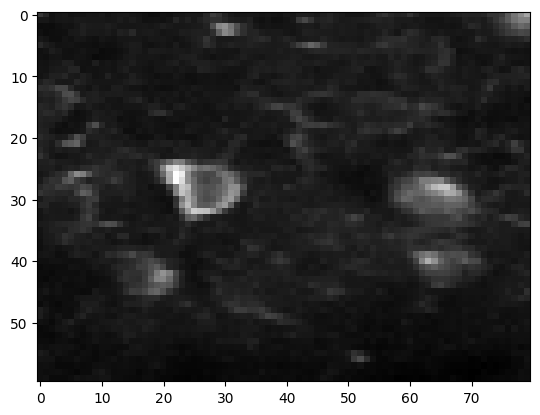

In [9]:
data = imread('data/demoMovie.tif')
rep_image = data[100:500, :, :].max(axis=0)
plt.imshow(rep_image, cmap='gray')

*How do I zoom into the cell I am interested in?*

**Example** Plot mean projection image cropped to Cell 1.

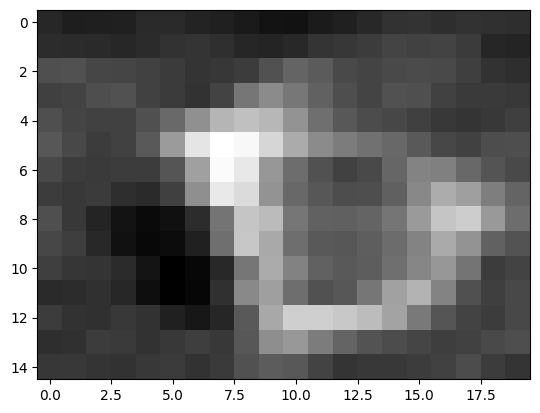

In [10]:
data = imread('data/demoMovie.tif')
rep_image = data[:, 20:35, 15:35].mean(axis=0)
plt.imshow(rep_image, cmap='gray')

Plot mean projection image cropped to Cell 2.

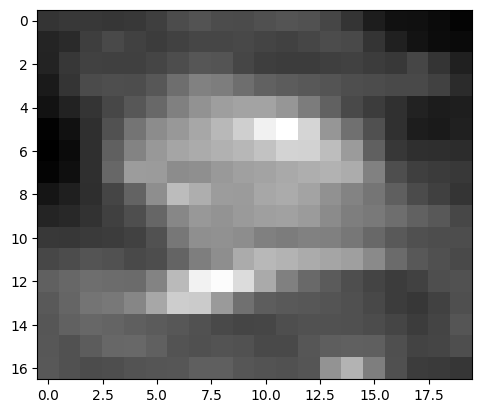

In [11]:
data = imread('data/demoMovie.tif')
rep_image = data[:, 23:40, 55:75].mean(axis=0)
plt.imshow(rep_image, cmap='gray')

Plot max projection of only the first 100 frames cropped to Cell 3.

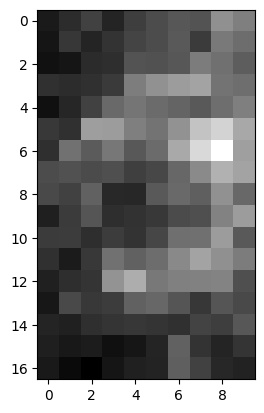

In [12]:
data = imread('data/demoMovie.tif')
rep_image = data[0:100, 23:40, 0:10].max(axis=0)
plt.imshow(rep_image, cmap='gray')

*How do I select a pixel from the neuron that I am interested in?*

**Example** Select a pixel from Cell 1.

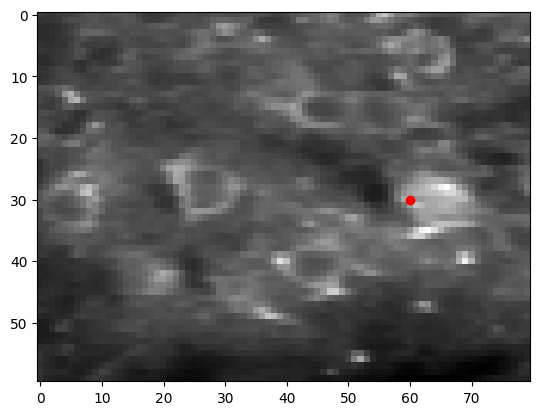

In [13]:
rep_image = data[:, :, :].mean(axis=0)
plt.imshow(rep_image, cmap='gray')
plt.scatter(60, 30, color='r')

Select a pixel from Cell 2.

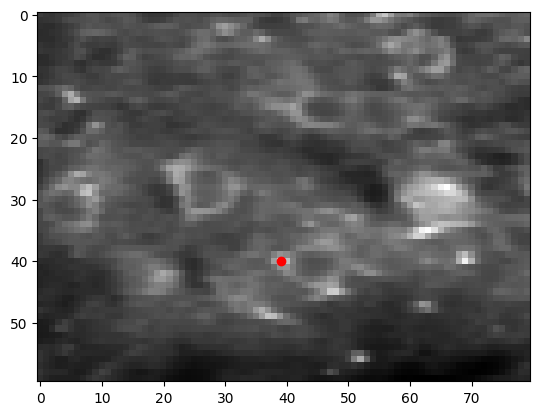

In [14]:
rep_image = data[:, :, :].mean(axis=0)
plt.imshow(rep_image, cmap='gray')
plt.scatter(39, 40, color='r')

Select a pixel from Cell 3.

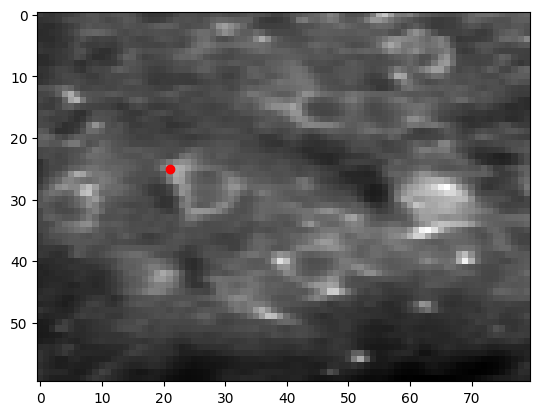

In [15]:
rep_image = data[:, :, :].mean(axis=0)
plt.imshow(rep_image, cmap='gray')
plt.scatter(21, 25, color='r')

*What does the activity of my neuron look like?*

**Example** Plot calcium trace extracted from Cell 1.

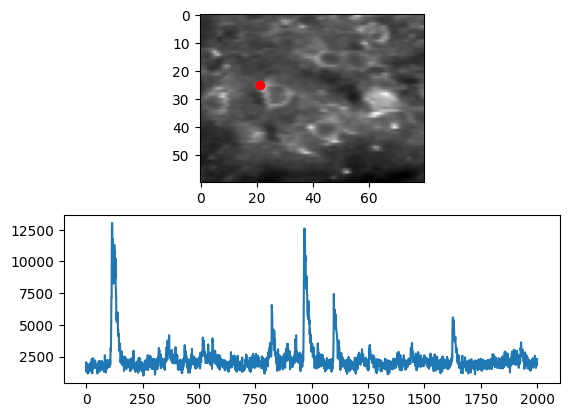

In [16]:
rep_image = data[:, :, :].mean(axis=0)
trace = data[:, 25, 21]

plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(21, 25, color='r')

plt.subplot(212)
plt.plot(trace)

Plot calcium trace extracted from Cell 2.

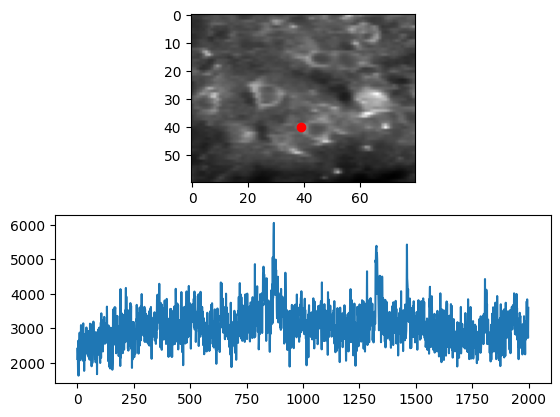

In [17]:
rep_image = data[:, :, :].mean(axis=0)
trace = data[:, 40, 39]

plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(39, 40, color='r')

plt.subplot(212)
plt.plot(trace)

Plot calcium trace extracted from Cell 3.

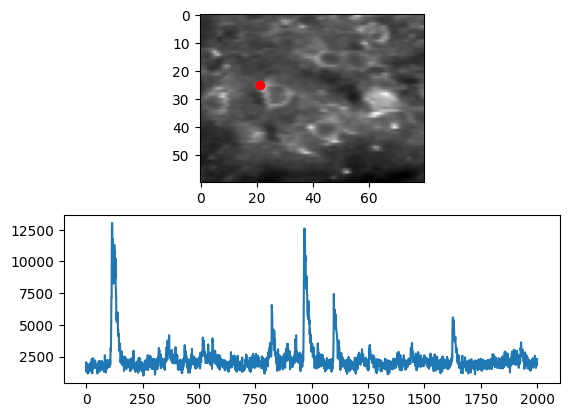

In [18]:
rep_image = data[:, :, :].mean(axis=0)
trace = data[:, 25, 21]

plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(21, 25, color='r')

plt.subplot(212)
plt.plot(trace)

## Neuropil Correction.

The brightness we see in a pixel is, usually, not just from the cell we care about. It also includes light from nearby tissue called neuropil. To get a cleaner signal, we subtract a portion of this surrounding signal. This process is called neuropil correction.

In [19]:
data = imread('data/demoMovie.tif')
rep_image = np.mean(data, axis=0)

*How do I get neuropil trace for correction and it's okay if it also contains some signal from neurons?*

**Example** Take global mean of all frames and pixels to get neuropil trace.

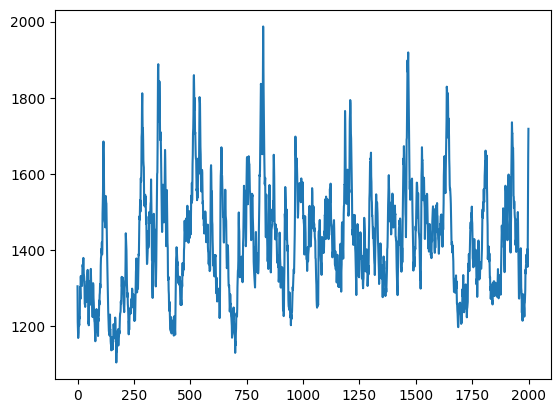

In [25]:
npil_trace = np.mean(data, axis=(1,2))
plt.plot(npil_trace)

Take global median of all frames and pixels to get neuropil trace.

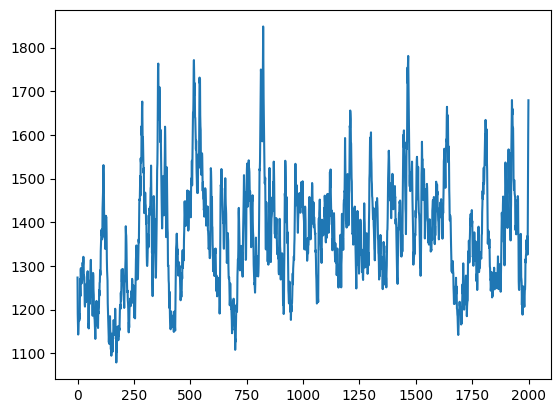

In [26]:
npil_trace = np.median(data, axis=(1,2))
plt.plot(npil_trace)

Take global mean of all frames and pixels to get neuropil trace.

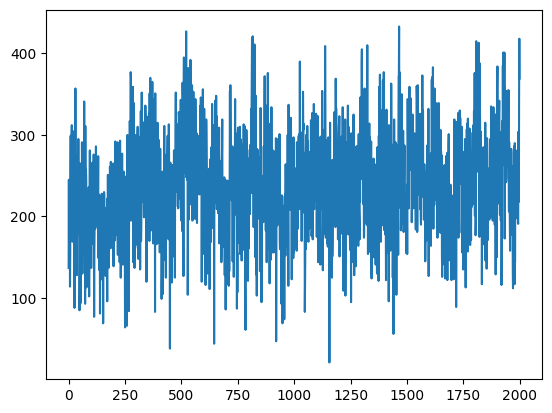

In [27]:
npil_trace = np.min(data, axis=(1,2))
plt.plot(npil_trace)

*How do I get neuropil trace from just outside my neuron?*

**Example** Extract neuropil trace from just outside Cell 1.

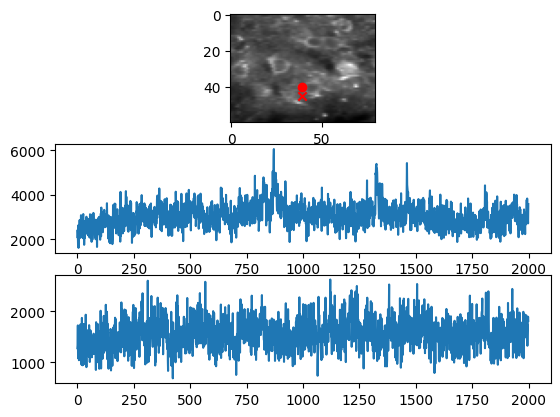

In [28]:
plt.subplot(311)
plt.imshow(rep_image, cmap='gray')
plt.scatter(39, 40, color='r')
plt.scatter(39, 45, color='r', marker='x')

plt.subplot(312)
plt.plot(data[:, 40, 39])

plt.subplot(313)
plt.plot(data[:, 45, 39])

Extract neuropil trace from just outside Cell 2.

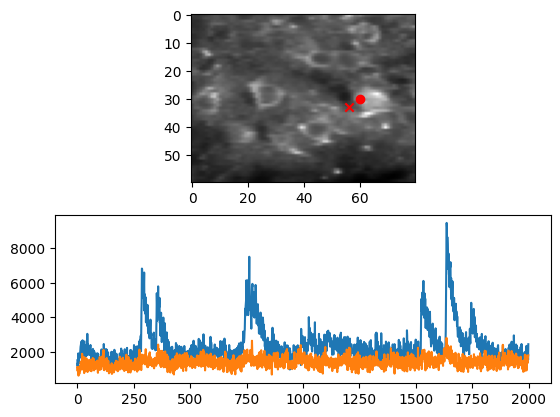

In [30]:
plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(60, 30, color='r')
plt.scatter(56, 33, color='r', marker='x')

plt.subplot(212)
plt.plot(data[:, 30, 60])
plt.plot(data[:, 33, 56])

Extract neuropil trace from just outside Cell 3.

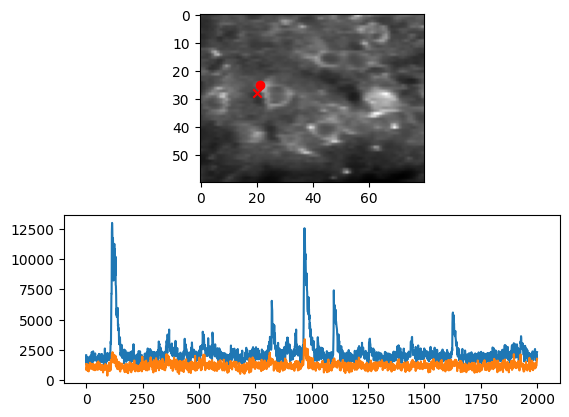

In [31]:
plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(21, 25, color='r')
plt.scatter(20, 28, color='r', marker='x')

plt.subplot(212)
plt.plot(data[:, 25, 21])
plt.plot(data[:, 28, 20])

*How should I do neuropil subtraction?*

**Example** Subtract neuropil trace from Cell 3 calcium trace with a scaling factor of 1.0.

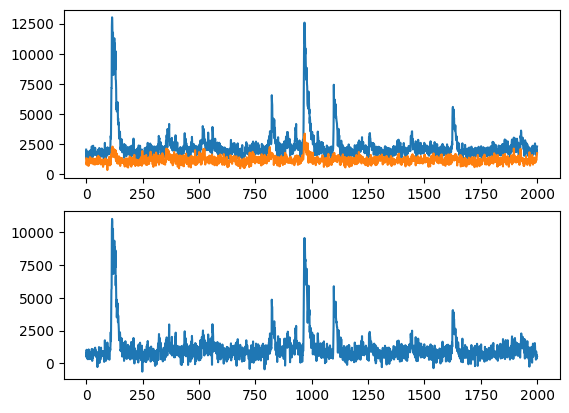

In [35]:
cell_trace = data[:, 25, 21]
neuropil_trace = data[:, 28, 20]
r = 1.0
F_corr = cell_trace - r*neuropil_trace

plt.subplot(211)
plt.plot(cell_trace)
plt.plot(neuropil_trace)

plt.subplot(212)
plt.plot(F_corr)

Subtract neuropil trace from Cell 2 calcium trace with a scaling factor of 0.7.

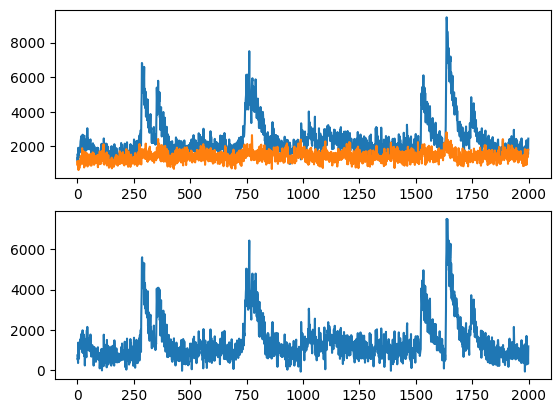

In [36]:
cell_trace = data[:, 30, 60]
neuropil_trace = data[:, 33, 56]
r = 0.7
F_corr = cell_trace - r*neuropil_trace

plt.subplot(211)
plt.plot(cell_trace)
plt.plot(neuropil_trace)

plt.subplot(212)
plt.plot(F_corr)

Subtract neuropil trace from Cell 1 calcium trace with a scaling factor of 1.0.

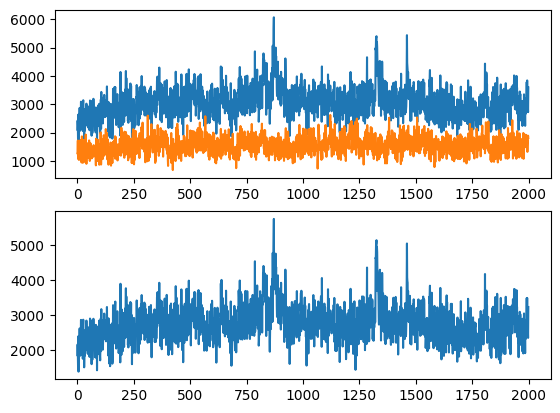

In [37]:
cell_trace = data[:, 40, 39]
neuropil_trace = data[:, 45, 39]
r = 0.2
F_corr = cell_trace - r*neuropil_trace

plt.subplot(211)
plt.plot(cell_trace)
plt.plot(neuropil_trace)

plt.subplot(212)
plt.plot(F_corr)

## Estimating Baseline Fluorescence (F0).

Even when a neuron is not active, the signal is not zero because of slow change in signal or noise. This resting level of fluorescence is called **baseline flurorescence** or **F0**. 

In [38]:
cell1_corr_trace = data[:, 40, 39] - 0.7 * data[:, 45, 39]
cell2_corr_trace = data[:, 30, 60] - 0.7 * data[:, 33, 56]
cell3_corr_trace = data[:, 25, 21] - 0.7 * data[:, 28, 20]

How do I get baseline activity of my cell and it's okay if I don't consider local variations?

**Example** Plot mean baseline activity of Cell 1

In [ ]:
F0 = np.mean(cell1_corr_trace)
plt.plot(cell1_corr_trace)
plt.axhline(F0, color='r')

In [ ]:
F0 = np.median(cell2_corr_trace)
plt.plot(cell2_corr_trace)
plt.axhline(F0, color='r')

In [ ]:
F0 = np.percentile(cell3_corr_trace, 10)
plt.plot(cell3_corr_trace)
plt.axhline(F0, color='r')

In [ ]:
# Smooth the trace
smoothed = gaussian_filter1d(cell2_corr_trace, sigma=100)

# Take minimum of the smoothed trace
F0 = np.min(smoothed)

# Plot
plt.plot(cell2_corr_trace)
plt.axhline(F0, color='r')

How do I consider local variations to estimate baseline activity of my cell?

**Example** Moving median window baseline to account for local variations Cell 1.

In [ ]:
F0 = median_filter(cell1_corr_trace, 501)
plt.plot(cell1_corr_trace)
plt.plot(F0, color='r')

In [ ]:
F0 = median_filter(cell2_corr_trace, 501)
plt.plot(cell2_corr_trace)
plt.plot(F0, color='r')

In [ ]:
F0 = median_filter(cell2_corr_trace, 1001)
plt.plot(cell2_corr_trace)
plt.plot(F0, color='r')

In [ ]:
F0 = median_filter(cell2_corr_trace, 11)
plt.plot(cell2_corr_trace)
plt.plot(F0, color='r')

## dF/F0 Normalization.

We usually want to quantify how much the fluorescence signal increases relative to that baseline so that we can compare signals from different neurons. This is done by computing **ΔF/F₀**, where:

$\Delta F/F_0 = \frac{F - F_0}{F_0}$


Here, **F** is the fluorescence at each time point, and **ΔF** (delta F) is the difference between the current signal and the baseline. The resulting ΔF/F₀ value expresses the signal change as a **fraction of the baseline**, which is useful for comparing activity levels across different cells or imaging sessions.

How do I remove baseline activity from my cell's activity?

**Example** Remove median baseline activity from cell 1.

In [ ]:
F0 = np.median(cell1_corr_trace)
df = cell1_corr_trace - F0

plt.subplot(211)
plt.plot(cell1_corr_trace)

plt.subplot(212)
plt.plot(df)

In [ ]:
F0 = median_filter(cell3_corr_trace, 201)
df = cell3_corr_trace - F0

plt.subplot(211)
plt.plot(cell3_corr_trace)

plt.subplot(212)
plt.plot(df)

In [ ]:
F0 = median_filter(cell3_corr_trace, 11)
df = cell3_corr_trace - F0

plt.subplot(211)
plt.plot(cell3_corr_trace)

plt.subplot(212)
plt.plot(df)



**Example** Plot df/f0 for cell 1

In [ ]:
F0 = median_filter(cell1_corr_trace, 201)
dff = (cell1_corr_trace - F0) / F0

plt.subplot(311)
plt.plot(cell1_corr_trace)
plt.plot(F0, color='r')

plt.subplot(312)
plt.plot(cell1_corr_trace - F0)

plt.subplot(313)
plt.plot(dff)

In [ ]:
F0 = median_filter(cell2_corr_trace, 201)
dff = (cell2_corr_trace - F0) / F0

plt.subplot(311)
plt.plot(cell2_corr_trace)
plt.plot(F0, color='r')

plt.subplot(312)
plt.plot(cell2_corr_trace - F0)

plt.subplot(313)
plt.plot(dff)

In [ ]:
F0 = median_filter(cell3_corr_trace, 201)
dff = (cell3_corr_trace - F0) / F0

plt.subplot(311)
plt.plot(cell3_corr_trace)
plt.plot(F0, color='r')

plt.subplot(312)
plt.plot(cell3_corr_trace - F0)

plt.subplot(313)
plt.plot(dff)